<div align='right'>Oleg Khomenko, olegkhomenkoru at gmail.com, March 2018</div>

# Problem
**Task:** 

Create a system that will automatically identify and markup language blocks in text document.

There is no pre-defined list of languages, but please take into consideration that Behavox operates all
over the world (Europe / America / Asia), so the system should be extensible and have an ability to
capture conceptual differences between major groups of languages and provide the best possible
identification granularity.

The main goal of this task is to demonstrate the ability to create requested classifier and all necessary
infrastructure (train / test datasets, etc.)
Choice of particular classification method is full responsibility of candidate.

**Input data:**

In Behavox we typically analyze different types of communications (SMS / chats / emails). Input
document can be any of those. Email messages tend to have formal structure, however, short
messages like SMS or chats can be difficult to deal with. Twitter messages can be a good proxy for
this type of communication.
It can be assumed that type of input document is also provided with document itself.

**Requirements:**
* Software Languages: Java, Python
* 3-rd party open source libraries can be used
* Document languages: Please specify at least 3 supported languages (English,...)

**Classifier**

Input: text document
Output: language blocks that are present in the document.
It’s necessary to present the description of algorithm and system evaluation metrics
All materials (source codes, description, ...) should be committed to repository at
bitbucket.org.

Please estimate the time required for completion of this task and communicate it in advance.

___

# Solution

This problem is usually described as "Language identification problem". 

The problem can be formulated as "Monolingual language identification" and "Multilingual language identification".
To solve this problem, one can use many different models with high accuracy metric (more than 90%).

**Main idea**

1. Use TFIDF based on char-n-grams, not words. For short-to-medium size texts it generally works better than words tokenization for langid problem.
2. Freq. distribution of n_grams is different in different languages;
3. One don't need to del. stop words (frequent words may be good features);
4. One don't need to perform stemming (suffixes, prefixes, etc. are usefull features in language identification problem);

**Data**

Two different data sources were used:
1. Twitter (dataset is manually parsed by me via tweepy w/ twitter api);
2. Wikipedia (dataset is manually parsed by me via wikipedia lib w/ wikipedia);

Target variables (classes) were extracted according to meta information from tweets and language from wikipedia page. Initial languages were chosen at random, however, the model may be generalized to other languages (see languages.json)

**Metric**<br>
`Accuracy` was chosen as the main metric for maximizing

**Algorithms**<br>
There are many algorithms which may perform well for NLP tasks (probabilistic models, linear models, NN etc.). 
Probabilistic classifiers have proved their stability and accuracy for the tasks of classifying texts.
This is why Multinomial Naive Bayes classifier is used in this problem as a baseline solution.
In addition I have tested Linear SVM and it works even better than MultinomialNB Classifier.

In this task I did not use neural networks. The choice of DNN architecture and training process may be time-consuming. It was a trade-off between my free time and accuracy of final model

** Assumptions and external libs**

1. Wikipedia dataset was parsed using wikipedia python lib<br> (```pip install wikipedia```)
2. (assumption) We work only with utf-8 <br>
(```pip install charder``` may be used)

**What was done**
* Dataset parser for random wikipedia pages and random tweets (see `parse_wiki()` and `parse_twitter()`
* Dataset generator<br>
```input: files in folders; 
   output: pd.Dataframe w/ paths and target values
```
* Simple text preprocessor (see `preprocess_tweets()`)
* Grid Search w/ cross validation was performed (using kfold=3) to choose some params.
* Couple plots were generated during the process
* Model was exported with `pickle` into separate .py file

**What else to do**
1. Feature engineering (aggregated statistics based on word lenghts, unique symbols etc.)
2. Different models for different data sources (emails, tweets, texts) + meta-algorithm on top of it
3. Use confusion matrix to detect similar languages or languages from the same group. Maximize accuracy for difficult sets of languages

_Some references are provided in the last part of the notebook_

In [3]:
##Requirements 
#!pip install nltk # NLP Toolkit
#!pip install wikipedia # Wikipedia API
#!pip install chardet # Charset detection
#1pip install tqdm # progress bar
#!pip install tweepy # Twitter API

__Import__

In [4]:
import re # preprocess data
import os # Working with file system
import logging # logging
import json
import pathlib # python 3.5+ is required
from fnmatch import fnmatch

# working with data and numbers
import pandas as pd
import numpy as np

# external
# - wikipedia
import wikipedia
# - twitter
import tweepy
from tweepy import OAuthHandler
# - chardet
import chardet # WAS NOT USED

import nltk
from nltk.corpus import stopwords, PlaintextCorpusReader # NLP

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer # NLP
from sklearn.naive_bayes import MultinomialNB # Models
from sklearn.pipeline import Pipeline # Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold # Validation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Validation
from sklearn.linear_model import SGDClassifier
from sklearn.externals import joblib # Save model

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Logger init.
logger = logging.getLogger('myapp')
hdlr = logging.FileHandler('./results.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.WARNING)

__Constants and Variables__

In [5]:
N_PAGES = 5 # Number of wiki pages per language
N_TWEETS = 100 # Number of tweets per language
RANDOM_STATE = 17
LANGUAGES_FILE = './languages.json'
CORPUS_ROOT = './data'

# should this jupyter parse more tweets ans wiki pages
PARSE_TWITTER = False
PARSE_WIKI = False

# twitter creds
if PARSE_TWITTER:
    TW_CONSUMER_KEY = %PLEASE_FILL%
    TW_CONSUMER_SECRET = %PLEASE_FILL%
    TW_ACCESS_TOKEN_KEY = %PLEASE_FILL%
    TW_ACCESS_TOKEN_SECRET = %PLEASE_FILL%


# supported languages
with open(LANGUAGES_FILE) as json_data:
    languages = json.load(json_data)
    labels = pd.DataFrame(languages).T.sort_values('class').index.values

In [363]:
def save_model(pipe):
    """
    Save model to the pkl file
    pipe — model
    """
    t = datetime.datetime.now()
    joblib.dump(pipe, 'model{}{}.pkl'.format(t.hour,t.minute), compress=5)

## 1. Parsing Wiki

In [6]:
def parse_wiki(n_pages=N_PAGES, languages=languages, path='./data/wiki'):
    """
    This function is used to parse random articles from Wiki using known list of languages
    
    n_pages — number of random pages to be parsed for each language (see wikipedia.random(pages=___))
    languages — dictionary with the following structure:
        languages = {'LANGUAGE': {'class': CLASS_NUMBER},
                     'LANGUAGE': {'class': CLASS_NUMBER}}
    
    output:
    None
    
    All data is placed into './data/wiki/%lang%/%page%'
    """
    
    logger.debug("Starting parsing from wiki..")
    for lang in tqdm.tqdm(languages.keys()):
        wikipedia.set_lang(lang)
        pages = wikipedia.random(pages=n_pages)
        logging.debug("Start parsing {}. Language — '{}'".format(pages, lang))
        
        if n_pages == 1: # then pages is 'str' not 'list' => should be converted
            pages = [pages]
        
        for page_name in pages:
            try:
                page = wikipedia.page(page_name, auto_suggest=False)

                if not os.path.exists('{}/{}/'.format(path, lang)):
                    os.makedirs('{}/{}/'.format(path, lang))

                with open('{}/{}/{}'.format(path, lang, page_name), 'w') as f:
                    f.write(str(page.content))
            except:
                logger.warning("Cannot parse '{}' for language '{}'".format(page_name, lang))

In [7]:
if PARSE_WIKI: # if you need to additionally parse wiki
    parse_wiki()

___

## 2. Parsing Twitter

In [8]:
if PARSE_TWITTER:
    # init. API
    auth = OAuthHandler(TW_CONSUMER_KEY, TW_CONSUMER_SECRET)
    auth.set_access_token(TW_ACCESS_TOKEN_KEY, TW_ACCESS_TOKEN_SECRET)
    api = tweepy.API(auth)


def parse_twitter(n_tweets, languages, api, path='./data/tw'):
    for lang in tqdm.tqdm(languages.keys()):
        pathlib.Path('{}/{}/'.format(path,lang)).mkdir(parents=True, exist_ok=True)
        for result in api.search(q='until:2019-01-01', count=n_tweets, lang=lang):
            with open('{}/{}/{}'.format(path, lang, result.id_str), 'w') as f:
                f.write(result.text)

In [9]:
if PARSE_TWITTER: # if you need to additionally parse twitter
    parse_twitter(N_TWEETS, languages, api)

___

# 3. Generate datasets from parsed data


In [10]:
def dataset_generator(root, pattern_to_exclude='.*', languages=languages):
    """
    Function returns a list of filenames with paths and labels

    input:
    root — path with /en/, /ru/ etc. folders inside;
    pattern_to_exclude — pattern used to ignore files
    
    output:
    returns filenames (list) and classes (list)
    """

    languages_df = pd.DataFrame(languages).T
    
    filenames = []
    classes = []

    for path, subdirs, files in os.walk(root):
        for name in files:
            if not fnmatch(name, pattern_to_exclude):
                filenames += [os.path.join(path, name)]
                classes += [languages_df.loc[path[-2:],'class']]
                
    res = pd.DataFrame([filenames, classes]).T
    
    res.columns = ['path', 'class']
    res['class'] = res['class'].astype('int')
    return res

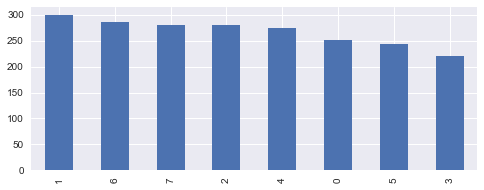

In [11]:
if not os.path.exists('./data/wiki'): # check if data was parse before
    logger.error("./data/wiki doesn't exist,\nplease exec. parse_wiki() first")
else:
    dataset_wiki = dataset_generator(root='./data/wiki')
    dataset_wiki['class'].value_counts().plot(kind='bar', figsize=(8,3)) # let's check if dataset is balanced

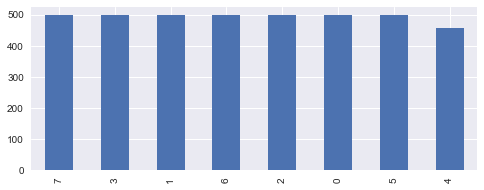

In [12]:
if not os.path.exists('./data/wiki'): # check if data was parse before
    logger.error("./data/wiki doesn't exist,\nplease exec. parse_wiki() first")
else:
    dataset_tw = dataset_generator(root='./data/tw')
    dataset_tw['class'].value_counts().plot(kind='bar', figsize=(8,3)) # let's check if dataset is balanced

```
OK, Now we have two datasets with target values.
Next step, we need to prepare one dataset, then split it to train and test subsets
```
____

# 4. Train Test Split

In [170]:
print("number of tweets:\t", dataset_tw.shape[0])
print("number of wiki pages:\t", dataset_wiki.shape[0])

# split. 0.25 for train set
tw_train, tw_test = train_test_split(dataset_tw, random_state=RANDOM_STATE)
wiki_train, wiki_test = train_test_split(dataset_wiki, random_state=RANDOM_STATE)
wiki_tw_test = pd.concat([wiki_test, tw_test], ignore_index=True)
wiki_tw_train = pd.concat([wiki_train, tw_train], ignore_index=True)
wiki_tw = pd.concat([dataset_tw, dataset_wiki], ignore_index=True)

number of tweets:	 3955
number of wiki pages:	 2136


# 5. Plots and statistics

In [14]:
# first, let's create one large file
# It may cause side-effects. Please be aware, while using.

def generate_aggregated_files():
    """
    Function generates aggregated files for each language and each source (tw, wiki)
    """
    for d, filename in [(dataset_wiki, 'wiki'), (dataset_tw, 'tw')]:
        for lang in d['class'].unique():
            with open('./data/{}_{}.txt'.format(filename, lang), 'w') as outfile:
                for fname in d[d['class'] == lang].path.values:
                    with open(fname) as infile:
                        for line in infile:
                            outfile.write(line)

In [15]:
generate_aggregated_files()

### Most freq. words

__ by data source__

In [16]:
inaug_tw = PlaintextCorpusReader(CORPUS_ROOT, 'tw.*txt')
inaug_wiki = PlaintextCorpusReader(CORPUS_ROOT, 'wiki.*txt')

# tweets
inaug_tw_freq = nltk.FreqDist(inaug_tw.words())
print('Twitter most common words:\n',inaug_tw_freq.most_common(10))

# wiki
inaug_wiki_freq = nltk.FreqDist(inaug_wiki.words())
print('Wiki most common words:\n',inaug_wiki_freq.most_common(10))

Twitter most common words:
 [('@', 3304), ('.', 3194), (':', 2368), ('t', 2096), ('/', 2070), ('https', 2032), ('://', 2022), ('co', 2005), (',', 1272), ('#', 1128)]
Wiki most common words:
 [('.', 40731), (',', 40253), ('de', 20018), ('==', 15141), ('-', 13526), ('(', 11939), ('la', 9197), ("'", 8443), ('the', 8065), (')', 7029)]


```
one can see that freq. distribution depends on an orignal data source
```

__ by language __

In [17]:
from nltk import FreqDist

masks = ['.*_{}.*txt'.format(i) for i in range(len(languages))]

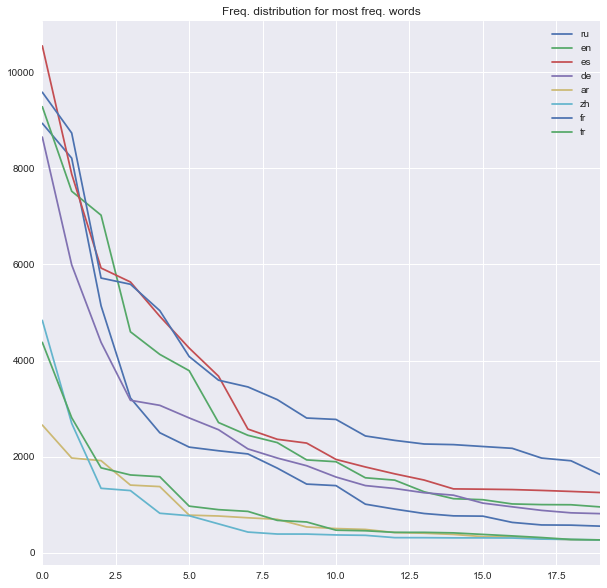

In [18]:
corpuses = [PlaintextCorpusReader(CORPUS_ROOT, mask) for mask in masks]

distributions = {}
for i, corpus in enumerate(corpuses):
    dist = dict(FreqDist(w.lower() for w in corpus.words()))
    distributions[i] = (sorted(dist.values(),reverse=True))
    
distributions = pd.DataFrame([
    pd.Series(distributions[key], name=key)[:20] 
    for key in distributions.keys()
])

distributions.index = labels

distributions.T.plot(figsize=(10,10), title='Freq. distribution for most freq. words')

_we see different freq. distribution for most common words in different languages
<br>this fact may be used for feature engineering process. However, let's start test different models
_

# Model #1 — Wiki train, Wiki + Twitter test
* __Description:__ Naive Bayes + TFIDF. _Baseline solution_
* __Train:__ wiki_train
* __Test__: wiki_test + tw_test
* __Metric__: Accuracy
* __Cross validation__: No
* __Random State__ = 17

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename',ngram_range=(1, 6), analyzer='char')),
    ('mnb', MultinomialNB())
])

In [ ]:
pipe.fit(wiki_train.path.values, wiki_train['class'].values)
accuracy_score(wiki_tw_test['class'].values, 
               pipe.predict(wiki_tw_test.path.values))

__result__: 0.88706500328299409 => this our baseline solution. Classifier is trained only on wikipedia pages
___

# Model #2 — Use not only wiki, but also twitter data
* __Hypothesis:__ Twitter corpus differs from regular language (wiki) — True
* __Description:__ Naive Bayes + TFIDF. 
* __Train:__ wiki_train + tw_train
* __Test__: wiki_test + tw_test
* __Metric__: Accuracy
* __Cross validation__: No
* __Random State__ = 17

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename',ngram_range=(1, 6), analyzer='char')),
    ('mnb', MultinomialNB())
])

In [ ]:
pipe.fit(wiki_tw_train.path.values, wiki_tw_train['class'].values)
accuracy_score(wiki_tw_test['class'].values, 
               pipe.predict(wiki_tw_test.path.values))

__result__: 0.93959290873276424 => using twitter data has improved the result

# Model #3 — GridSearch over [n_gram length, preprocessor, use_idf]
* __Description:__ 
Here we test whether we need preprocess tweets to achieve better results or not. 
At the same time we test different params of the classification algorithm 
* __Train:__ wiki_train + tw_train
* __Test__: wiki_train + tw_train (cross validation)
* __Metric__: Accuracy
* __Cross validation__: Yes, 3-fold
* __Random State__ = 17
* __FINAL RESULT__: wiki_train + tw_train for train; wiki_test + tw_test for test

In [39]:
# we use lambda simple one-liners here to preprocess tweets
remove_urls = lambda s: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', s, flags=re.MULTILINE)
remove_hashtags = lambda s: re.sub(r'#(\w+)', '', s, flags=re.MULTILINE)
remove_at = lambda s: re.sub(r'@(\w+)', '', s, flags=re.MULTILINE)

In [40]:
def preprocess_tweet(s):
    """
    This function preprocess text, removing twitter-specific words 
    @WORD - links, 
    #WORD - hashtags,
    http(s):// - urls
    """
    s = remove_urls(s)
    s = remove_hashtags(s)
    s = remove_at(s)
    return s

In [21]:
# uncomment to get full grid of params
param_grid = [
    {        
        'tfidf__preprocessor': [None, preprocess_tweet],
    },
#    {
#        'tfidf__ngram_range': [(1, 2), (1, 4), (1, 6), (2, 2), (2, 4), (2, 6)],
#        'tfidf__preprocessor': [None, preprocess_tweet],
#        'tfidf__use_idf': (True, False),
#        'tfidf__stop_words': [None, 'english']
#    }
]

In [22]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename', ngram_range=(1, 6), analyzer='char')),
    ('mnb', MultinomialNB())
])

In [23]:
grid_search_cv = GridSearchCV(pipe, param_grid=param_grid)
grid_search_cv.fit(wiki_tw_train.path.values, wiki_tw_train['class'].values)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='filename',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 6), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'tfidf__preprocessor': [None, <function preprocess_tweet at 0x1145b4a60>]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
# mean 
print("mean test score:\t", grid_search_cv.cv_results_['mean_test_score'])
print("std:\t\t\t",grid_search_cv.cv_results_['std_test_score'], "--> is ok")

mean test score:	 [ 0.91746935  0.94570928]
std:			 [ 0.02201617  0.00463568] --> is ok


__Grid Search results:__
1. Best ngram_range is (1,6), however one should always think about computational costs;
2. Removing urls increases accuracy;
3. Removing hashtags improves accuracy;
4. Removing @-links increases accuracy;
5. Removing stop-words reduces accuracy;
6. Mean error std is OK. This means that the model is fairly stable for the selected data sources

In [26]:
# set preprocessor
pipe.named_steps.tfidf.set_params(preprocessor=preprocess_tweet)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='filename',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 6), norm='l2',
        preprocessor=<function preprocess_tweet at 0x1145b4a60>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

In [27]:
pipe.fit(wiki_tw_train.path.values, wiki_tw_train['class'].values)
accuracy_score(wiki_tw_test['class'].values, 
               pipe.predict(wiki_tw_test.path.values))

0.95666447800393961

__result__: 0.95666447800393961 — It's getting better

___

# Model #4 — SGD
* __Description:__ Linear SVM on TFIDF (+ Preprocessing)
* __Train:__ wiki_train + tw_train
* __Test__: wiki_test + tw_test
* __Metric__: Accuracy
* __Cross validation__: No
* __Random State__ = 17

In [171]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename', ngram_range=(1, 6),
                              max_df=.2, min_df=.01,
                              analyzer='char', preprocessor=preprocess_tweet)),
    ('svm', SGDClassifier(random_state=RANDOM_STATE)) 
])

/Users/ko/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [178]:
res_SGD = cross_val_score(pipe, wiki_tw.path.values, wiki_tw['class'].values)

__result__: 0.96585686145764937 => even better results

_Due to time constraints, this will be my final selected model_

### Let's plot confusion matrix

In [ ]:
y_test = wiki_tw_test['class'].values # get target values for test dataset
y_predicted = pipe.predict(wiki_tw_test.path.values) # get predicted values for test dataset

In [ ]:
# getting labels instead of language_id
labels = pd.DataFrame(languages).T.sort_values('class').index.values

# some metrics
print(classification_report(y_test, y_predicted,
                            target_names=labels))

# getting confusion matrix
cm = confusion_matrix(y_test, y_predicted)

# visualization
percentage_matrix = 100 * cm / cm.sum(axis=1).astype(float)
plt.figure(figsize=(10, 10))
sns.heatmap(percentage_matrix, annot=True,  fmt='.2f', xticklabels=labels, yticklabels=labels);
plt.title('Confusion Matrix for Languages(Percentages)');

__Conclusion:__ 
we see some misclassification between ('zh','en') and other language pairs<br>
=> to improve overall accuracy one may spend time tuning models, engineering features and preprocess data for these language pairs

___

# PREDICTION SECTION

In [649]:
pipe.set_params(tfidf__input='content')

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.2, max_features=None, min_df=0.01,
        ngram_range=(1, 6), norm='l2',
        preprocessor=<function pre...se_idf=True, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [648]:
FILEPATH = './results.log'
labels[pipe.predict([FILEPATH])[0]]

'en'

# Update 01

# Improvements: Better preprocessing, GridSearch over many params, Model size reduction

__Improve preprocessing__

In [371]:
def preprocess_tweet(s):
    """
    This function preprocess text, removing twitter-specific words 
    @WORD - links, 
    #WORD - hashtags,
    http(s):// - urls
    """
    s = remove_urls(s)
    s = remove_hashtags(s)
    s = remove_at(s)
    
    # added
    s = re.sub(r'[0-9]+|\n|', '', s, flags=re.MULTILINE) # numbers and \n symbols
    s = re.sub(r'[A-Z]{2,}', '', s, flags=re.MULTILINE)  # Abbreviations
    s = re.sub(r'[!$%^&*]', '', s, flags=re.MULTILINE) # Special chars
    return s

In [372]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename', ngram_range=(1, 6), 
                              max_df=.2, min_df=.01,
                              analyzer='char', preprocessor=preprocess_tweet)),
    ('mnb', MultinomialNB())
])

__Gridsearch__

In [375]:
# uncomment to get full grid of params
param_grid = [
    {
        'tfidf__ngram_range': [(1, 2), (1, 4), (1, 6), (2, 2), (2, 4), (2, 6)],
    },
    {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__max_df': [.1, .15, .2],
        'tfidf__min_df': [.01, .02, .05],
        'tfidf__max_features': [1000, 5000, 10000, 12500, 15000, 17500, None]
    }
]

In [376]:
grid_search_cv = GridSearchCV(pipe, param_grid=param_grid)
grid_search_cv.fit(wiki_tw_train.path.values, wiki_tw_train['class'].values)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='filename',
        lowercase=True, max_df=0.2, max_features=None, min_df=0.01,
        ngram_range=(1, 6), norm='l2',
        preprocessor=<function pr...se_idf=True, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'tfidf__ngram_range': [(1, 2), (1, 4), (1, 6), (2, 2), (2, 4), (2, 6)]}, {'tfidf__max_df': [0.1, 0.15, 0.2], 'tfidf__max_features': [1000, 5000, 10000, 12500, 15000, 17500, None], 'tfidf__min_df': [0.01, 0.02, 0.05], 'tfidf__stop_words': [None, 'english']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

__Check model's number of features__

In [408]:
pipe.fit(wiki_tw.path, wiki_tw['class'])

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='filename',
        lowercase=True, max_df=0.2, max_features=None, min_df=0.01,
        ngram_range=(1, 6), norm='l2',
        preprocessor=<function pr...se_idf=True, vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [409]:
mnb = pipe.named_steps['mnb']
tfidf = pipe.named_steps['tfidf']

In [650]:
print("Number of features:\t",mnb.coef_.shape[1])

Number of features:	 24758


* Original Feature Space: 3219859<br>
* New Feature Space: 24779 (and best accuracy on CV=kfold3)

__Result:__ *The model was improved using min_df and max_df params and additional preprocessing. The model size was reduced*

___

# Feature importances

In [606]:
tfidf = pipe.named_steps['tfidf']
coef = pd.DataFrame(pipe.named_steps['mnb'].coef_).T
coef['feature'] = tfidf.get_feature_names()
coef.set_index('feature', inplace=True)
coef.columns = labels

In [629]:
res = []
for col in coef.columns:
    res += [coef.sort_values(col, ascending=False).head(50).index]
    
pd.DataFrame(res, index=labels).T.to_csv("top50_features_by_language.csv")

__Result:__ *Top-50 features were saved into the separate csv-file*

___

# Misclassified documents analysis

In [832]:
pipe.set_params(tfidf__input='filename')
X = wiki_tw
y_pred = pipe.predict(X.path) # Predicted values
X['y_pred'] = y_pred # Add predicted values as a separate column

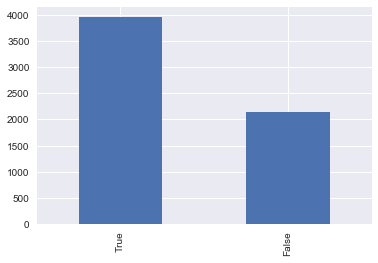

In [705]:
value_counts_orig = X.path.apply(lambda x: "./data/tw/" in x).value_counts()
value_counts_orig[True] / value_counts[False]
value_counts_orig.plot(kind='bar')

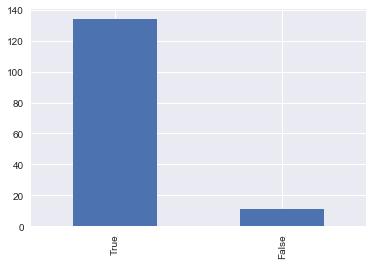

In [702]:
value_counts_misclass = X[X['class'] != X.y_pred].path.apply(lambda x: "./data/tw/" in x).value_counts()
value_counts_misclass[True] / value_counts_misclass[False]
value_counts_misclass.plot(kind='bar')

__Result:__ *It's clear, twitter documents are harder to classify*

__Let's get errors on cross_val__

In [891]:
kfold = StratifiedKFold(random_state=RANDOM_STATE)

pipe.set_params(tfidf__input='filename')
X = wiki_tw
X['predicted'] = -1
X['text'] = None
for train, test in kfold.split(X.path, X['class']):
    pipe.fit(X.iloc[train].path, X.iloc[train]['class'])
    X['predicted'].iloc[test] = pipe.predict(X.iloc[test].path)

/Users/ko/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/ko/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/ko/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._se

In [892]:
text = []
for path in X.loc[X.predicted != X['class'],'path']:
    with open(path, 'r') as f:
        text += [f.read()]

In [893]:
X.loc[X.predicted != X['class'], 'text'] = text

In [911]:
X.loc[X.predicted != X['class'], ~(X.columns == 'y_pred')]

path  class  predicted  \
467          ./data/tw/de/976039440547278848      3          1   
477          ./data/tw/de/976039442489098240      3          7   
484          ./data/tw/de/976039443508408320      3          1   
487          ./data/tw/de/976039443667746816      3          1   
504          ./data/tw/de/976039447233024001      3          7   
505          ./data/tw/de/976039448461930496      3          1   
515          ./data/tw/de/976039451179798530      3          1   
518          ./data/tw/de/976039451959971840      3          1   
525          ./data/tw/de/976039452760920064      3          1   
534          ./data/tw/de/976039455973937152      3          1   
538          ./data/tw/de/976039457072734208      3          1   
546          ./data/tw/de/976039458356318210      3          1   
556          ./data/tw/de/976039459476008960      3          1   
581          ./data/tw/de/976051078448820225      3          1   
587          ./data/tw/de/976051080814645251      3          1   
588          ./data/tw/de/976051080843870208      3          7   
599          ./data/tw/de/976051082815332352      3          1   
608          ./data/tw/de/976051084035735557      3          7   
638          ./data/tw/de/976051091254235136      3          6   
654          ./data/tw/de/976051095616270336      3          1   
683          ./data/tw/de/976051199706324993      3          1   
695          ./data/tw/de/976051203225288705      3          1   
699          ./data/tw/de/976051204760457216      3          1   
706          ./data/tw/de/976051206198935552      3          1   
733          ./data/tw/de/976051213291737088      3          2   
748          ./data/tw/de/976051216315756545      3          1   
750          ./data/tw/de/976051216508579840      3          1   
760          ./data/tw/de/976066416465137664      3          1   
766          ./data/tw/de/976066417576554496      3          7   
767          ./data/tw/de/976066417815584768      3          6   
...                                      ...    ...        ...   
5578   ./data/wiki/tr/4. periyot elementleri      7          1   
5611  ./data/wiki/tr/Auftrag Deutsches Reich      7          3   
5635  ./data/wiki/tr/Cartoon Network Studios      7          1   
5712          ./data/wiki/tr/Jičín ilçesi      7          3   
5820                  ./data/wiki/tr/Şayzar      7          1   
5861                ./data/wiki/zh/Unlock Me      5          1   
5864                     ./data/wiki/zh/三明苦竹      5          1   
5885                ./data/wiki/zh/佩魯瓦蘇洞國家公園      5          1   
5905                   ./data/wiki/zh/卡米亞尼夫卡      5          0   
5907                     ./data/wiki/zh/印度緋鯉      5          1   
5913                    ./data/wiki/zh/台湾石豆兰      5          7   
5930                      ./data/wiki/zh/奇鱗魨      5          1   
5932                   ./data/wiki/zh/安坪十大功劳      5          1   
5936                    ./data/wiki/zh/客家震旦介      5          1   
5937                  ./data/wiki/zh/宽萼圆锥铁线莲      5          1   
5947                  ./data/wiki/zh/左 (插畫家)      5          1   
5961             ./data/wiki/zh/戈爾巴奇 (科澤列齊區)      5          0   
5964                     ./data/wiki/zh/捷列姆涅      5          0   
5965                    ./data/wiki/zh/捷捷里夫卡      5          0   
5966                        ./data/wiki/zh/政      5          1   
5970                      ./data/wiki/zh/斑鬚蝽      5          1   
5978                  ./data/wiki/zh/松崗紅芝麻蝸牛      5          1   
5985                     ./data/wiki/zh/棕樸麗魚      5          1   
6002                     ./data/wiki/zh/焦爾教堂      5          7   
6009                  ./data/wiki/zh/直落亚逸地铁站      5          1   
6029                     ./data/wiki/zh/结构因子      5          1   
6030                    ./data/wiki/zh/缩羽肋毛蕨      5          1   
6036                    ./data/wiki/zh/臺灣同蜾嬴      5          1   
6037                ./data/wiki/zh/臺灣短翅長筒金花蟲      5          1   
6072          

# What else to do:
* Better denoising techniques (smiles, international abbreviations, etc.)
* Feature engineering (aggregated statistics, pos)
* CNN, RNN and other NN may be used:<br>
https://github.com/lukaszkm/machinelearningexp/blob/master/Deep_Learning_Language_identification.ipynb
* SVM may be tested on lower dim. feature vectors
* GBM shows no good results with tfidf features

__References__
1. http://www.machinelearning.ru/wiki/images/a/a9/Rysmyatova_report.pdf
2. https://www.kaggle.com/rtatman/analyzing-multilingual-data
3. https://bugra.github.io/work/notes/2014-12-26/language-detector-via-scikit-learn/

___